In [1]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device}...')

Using cuda...


In [2]:
from datasets import load_dataset

fever_plus = load_dataset("tommasobonomo/sem_augmented_fever_nli")

c:\Users\anon\miniconda3\envs\nlp\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import pandas as pd
pd.DataFrame(fever_plus["train"][0])

,id,premise,hypothesis,label,wsd,srl
premise,150448,Roman Atwood . He is best known for his vlogs ...,Roman Atwood is a content creator.,ENTAILMENT,"[{'index': 0, 'text': 'Roman', 'pos': 'ADJ', '...","{'tokens': [{'index': 0, 'rawText': 'Roman'}, ..."
hypothesis,150448,Roman Atwood . He is best known for his vlogs ...,Roman Atwood is a content creator.,ENTAILMENT,"[{'index': 0, 'text': 'Roman', 'pos': 'PROPN',...","{'tokens': [{'index': 0, 'rawText': 'Roman'}, ..."


In [4]:
" ".join([wsd['pos'] for wsd in fever_plus['train'][0]["wsd"]["premise"]])             # create a sentence with the list of all the POS tags sepaated by space

'ADJ PROPN PUNCT PRON AUX ADV VERB ADP PRON NOUN PUNCT SCONJ PRON VERB NOUN ADP PRON NOUN ADP DET ADJ NOUN PUNCT PRON VERB NOUN PUNCT PUNCT PUNCT X PUNCT PUNCT AUX DET NOUN ADP NUM NUM NOUN CCONJ NUM NUM NOUN PUNCT PRON ADV AUX DET PROPN NOUN VERB PUNCT PUNCT PROPN PUNCT PUNCT SCONJ PRON VERB NOUN PUNCT'

In [5]:
# free up CUDA space and optimize space used
torch.cuda.empty_cache()
torch.cuda.set_per_process_memory_fraction(0.95, 0)  # Use 95% of GPU memory
#torch.cuda.set_max_split_size_mb(256)  # Set max split size to 256MB


In [6]:
# combine the elements from a fever entry to prepare a feasible input for 
def preprocess_input(entry, tokenizer, use_POS=True):

    # Sample premise and hypothesis with POS tagging
    premise = entry["premise"]
    hypothesis = entry["hypothesis"]

    if use_POS:
        # Corresponding POS tags (this is just a placeholder for the actual POS tags)
        premise_pos = " ".join([wsd['pos'] for wsd in entry["wsd"]["premise"]])             # create a sentence with the list of all the POS tags sepaated by space
        hypothesis_pos = " ".join([wsd['pos'] for wsd in entry["wsd"]["hypothesis"]])       # 

        # Combine text with POS tags
        premise_with_pos = f"{premise} POS: {premise_pos}"
        hypothesis_with_pos = f"{hypothesis} POS: {hypothesis_pos}"
        
        # Prepare the combined input for the model
        combined_input = f"[CLS] {premise_with_pos} [SEP] {hypothesis_with_pos}"
        encoding = tokenizer(combined_input, truncation=True, padding='max_length', max_length=438)
    
    else:
        combined_input = f"[CLS] {premise} [SEP] {hypothesis}"
        encoding = tokenizer(combined_input, truncation=True, padding='max_length', max_length=256)

    # Map labels as integers representing the classes
    label_map = {'ENTAILMENT': 0, 'CONTRADICTION': 1, 'NEUTRAL': 2}
    int_label = label_map[entry['label']]


    return {**encoding, 'label': int_label}




In [7]:
import torch
from transformers import DebertaV2Tokenizer, DebertaV2ForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset, load_metric

# Load the DeBERTa tokenizer 
tokenizer = DebertaV2Tokenizer.from_pretrained('microsoft/deberta-v3-xsmall')

# Apply preprocessing to datasets
train_dataset = fever_plus['train'].map(preprocess_input, fn_kwargs={'tokenizer': tokenizer, 'use_POS':True})
val_dataset = fever_plus['validation'].map(preprocess_input, fn_kwargs={'tokenizer': tokenizer, 'use_POS':True})
test_dataset = fever_plus['test'].map(preprocess_input, fn_kwargs={'tokenizer': tokenizer, 'use_POS':True})

# Set format for PyTorch
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])



Map: 100%|██████████| 2287/2287 [00:04<00:00, 457.46 examples/s]


In [8]:
'''
def compute_max_length(dataset, tokenizer):
    lengths = []
    for entry in dataset:
        premise = entry["premise"]
        hypothesis = entry["hypothesis"]
        
        premise_with_pos = f"{premise} POS: {' '.join([wsd['pos'] for wsd in entry['wsd']['premise']])}"
        hypothesis_with_pos = f"{hypothesis} POS: {' '.join([wsd['pos'] for wsd in entry['wsd']['hypothesis']])}"
        
        combined_input = f"[CLS] {premise_with_pos} [SEP] {hypothesis_with_pos}"
        encoding = tokenizer(combined_input, truncation=False, padding=False)
        
        lengths.append(len(encoding['input_ids']))
    
    # Analyze the distribution of lengths
    import numpy as np
    lengths = np.array(lengths)
    print(f"Mean length: {np.mean(lengths)}")
    print(f"95th percentile length: {np.percentile(lengths, 95)}")
    print(f"Max length: {np.max(lengths)}")

    return lengths


lenghts = compute_max_length(fever_plus['train'], tokenizer)
'''
# lenghts are: mean 210, 95th 438, max 3728

'\ndef compute_max_length(dataset, tokenizer):\n    lengths = []\n    for entry in dataset:\n        premise = entry["premise"]\n        hypothesis = entry["hypothesis"]\n        \n        premise_with_pos = f"{premise} POS: {\' \'.join([wsd[\'pos\'] for wsd in entry[\'wsd\'][\'premise\']])}"\n        hypothesis_with_pos = f"{hypothesis} POS: {\' \'.join([wsd[\'pos\'] for wsd in entry[\'wsd\'][\'hypothesis\']])}"\n        \n        combined_input = f"[CLS] {premise_with_pos} [SEP] {hypothesis_with_pos}"\n        encoding = tokenizer(combined_input, truncation=False, padding=False)\n        \n        lengths.append(len(encoding[\'input_ids\']))\n    \n    # Analyze the distribution of lengths\n    import numpy as np\n    lengths = np.array(lengths)\n    print(f"Mean length: {np.mean(lengths)}")\n    print(f"95th percentile length: {np.percentile(lengths, 95)}")\n    print(f"Max length: {np.max(lengths)}")\n\n    return lengths\n\n\nlenghts = compute_max_length(fever_plus[\'train\'], tok

In [9]:
# TRAINING!!


# Load the DeBerta v3 model
model = DebertaV2ForSequenceClassification.from_pretrained('microsoft/deberta-v3-xsmall', num_labels=3)

# Define the training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=4,  # Simulate batch size of 8*4=32 but without loading all at once
    per_device_eval_batch_size=1,
    num_train_epochs=5,
    weight_decay=0.01,
    fp16=True,                       # Mixed precision training (weight are in float16)
    no_cuda=False  # Use CPU instead of GPU
)


# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

# Train the model
trainer.train()

# Evaluate the model
#trainer.evaluate()


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-xsmall and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\anon\miniconda3\envs\nlp\Lib\site-packages\transformers\training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
c:\Users\anon\miniconda3\envs\nlp\Lib\site-packages\accelerate\accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
  6%|▋         | 500/7980 [1:17:36<19:12:51,  9.25s/it]

{'loss': 0.647, 'grad_norm': 5.158054828643799, 'learning_rate': 1.87468671679198e-05, 'epoch': 0.31}


 13%|█▎        | 1000/7980 [2:34:44<17:55:46,  9.25s/it]

{'loss': 0.449, 'grad_norm': 4.427201747894287, 'learning_rate': 1.749624060150376e-05, 'epoch': 0.63}


 19%|█▉        | 1500/7980 [3:51:52<16:39:55,  9.26s/it]

{'loss': 0.4251, 'grad_norm': 2.7518105506896973, 'learning_rate': 1.624561403508772e-05, 'epoch': 0.94}


                                                        
 20%|██        | 1596/7980 [4:11:19<16:25:05,  9.26s/it]

{'eval_loss': 0.7372671365737915, 'eval_runtime': 273.4881, 'eval_samples_per_second': 8.366, 'eval_steps_per_second': 8.366, 'epoch': 1.0}


 25%|██▌       | 2000/7980 [5:14:01<15:26:37,  9.30s/it] 

{'loss': 0.3759, 'grad_norm': 4.1460795402526855, 'learning_rate': 1.4992481203007521e-05, 'epoch': 1.25}


 31%|███▏      | 2500/7980 [6:31:35<14:09:18,  9.30s/it]

{'loss': 0.3708, 'grad_norm': 3.2597908973693848, 'learning_rate': 1.3739348370927319e-05, 'epoch': 1.57}


 38%|███▊      | 3000/7980 [7:49:21<12:53:28,  9.32s/it]

{'loss': 0.3564, 'grad_norm': 2.9030721187591553, 'learning_rate': 1.248621553884712e-05, 'epoch': 1.88}


                                                        
 40%|████      | 3193/7980 [8:23:57<12:13:32,  9.19s/it]

{'eval_loss': 0.7466031312942505, 'eval_runtime': 273.5547, 'eval_samples_per_second': 8.364, 'eval_steps_per_second': 8.364, 'epoch': 2.0}


 44%|████▍     | 3500/7980 [9:37:43<18:04:01, 14.52s/it] 

{'loss': 0.3352, 'grad_norm': 4.200982570648193, 'learning_rate': 1.1233082706766919e-05, 'epoch': 2.19}


 50%|█████     | 4000/7980 [11:38:17<15:56:43, 14.42s/it]

{'loss': 0.3181, 'grad_norm': 4.335425853729248, 'learning_rate': 9.979949874686718e-06, 'epoch': 2.51}


 56%|█████▋    | 4500/7980 [13:38:40<13:54:48, 14.39s/it]

{'loss': 0.319, 'grad_norm': 4.557716369628906, 'learning_rate': 8.726817042606517e-06, 'epoch': 2.82}


                                                         
 60%|██████    | 4789/7980 [14:43:17<8:09:33,  9.21s/it]

{'eval_loss': 0.713811457157135, 'eval_runtime': 273.3697, 'eval_samples_per_second': 8.37, 'eval_steps_per_second': 8.37, 'epoch': 3.0}


 63%|██████▎   | 5000/7980 [15:32:39<11:54:38, 14.39s/it]

{'loss': 0.2992, 'grad_norm': 7.325547218322754, 'learning_rate': 7.473684210526316e-06, 'epoch': 3.13}


 69%|██████▉   | 5500/7980 [17:33:04<9:54:38, 14.39s/it] 

{'loss': 0.2854, 'grad_norm': 6.902440071105957, 'learning_rate': 6.223057644110277e-06, 'epoch': 3.45}


 75%|███████▌  | 6000/7980 [19:33:28<7:54:54, 14.39s/it] 

{'loss': 0.2923, 'grad_norm': 3.465545177459717, 'learning_rate': 4.969924812030076e-06, 'epoch': 3.76}


                                                        
 80%|████████  | 6386/7980 [21:13:30<6:15:58, 14.15s/it]

{'eval_loss': 0.7740113139152527, 'eval_runtime': 425.5744, 'eval_samples_per_second': 5.376, 'eval_steps_per_second': 5.376, 'epoch': 4.0}


 81%|████████▏ | 6500/7980 [21:40:55<5:57:22, 14.49s/it]  

{'loss': 0.273, 'grad_norm': 4.418797969818115, 'learning_rate': 3.7167919799498746e-06, 'epoch': 4.07}


 88%|████████▊ | 7000/7980 [23:41:21<3:57:42, 14.55s/it]

{'loss': 0.2629, 'grad_norm': 10.50509262084961, 'learning_rate': 2.4636591478696745e-06, 'epoch': 4.38}


 94%|█████████▍| 7500/7980 [25:31:36<1:13:33,  9.19s/it]

{'loss': 0.2649, 'grad_norm': 4.186285495758057, 'learning_rate': 1.2130325814536342e-06, 'epoch': 4.7}


                                                        
100%|██████████| 7980/7980 [26:49:46<00:00, 12.10s/it]

{'eval_loss': 0.7918862104415894, 'eval_runtime': 273.2713, 'eval_samples_per_second': 8.373, 'eval_steps_per_second': 8.373, 'epoch': 5.0}
{'train_runtime': 96586.7412, 'train_samples_per_second': 2.645, 'train_steps_per_second': 0.083, 'train_loss': 0.34633619361055223, 'epoch': 5.0}


TrainOutput(global_step=7980, training_loss=0.34633619361055223, metrics={'train_runtime': 96586.7412, 'train_samples_per_second': 2.645, 'train_steps_per_second': 0.083, 'total_flos': 1.4390385496304544e+16, 'train_loss': 0.34633619361055223, 'epoch': 4.998434074538052})

In [10]:
# save model and tokenizer
model.save_pretrained('./saved_model')
tokenizer.save_pretrained('./saved_model')


('./saved_model\\tokenizer_config.json',
 './saved_model\\special_tokens_map.json',
 './saved_model\\spm.model',
 './saved_model\\added_tokens.json')

100%|██████████| 2287/2287 [04:32<00:00,  8.39it/s]


F1 Score on the test set: 0.7319600225131008


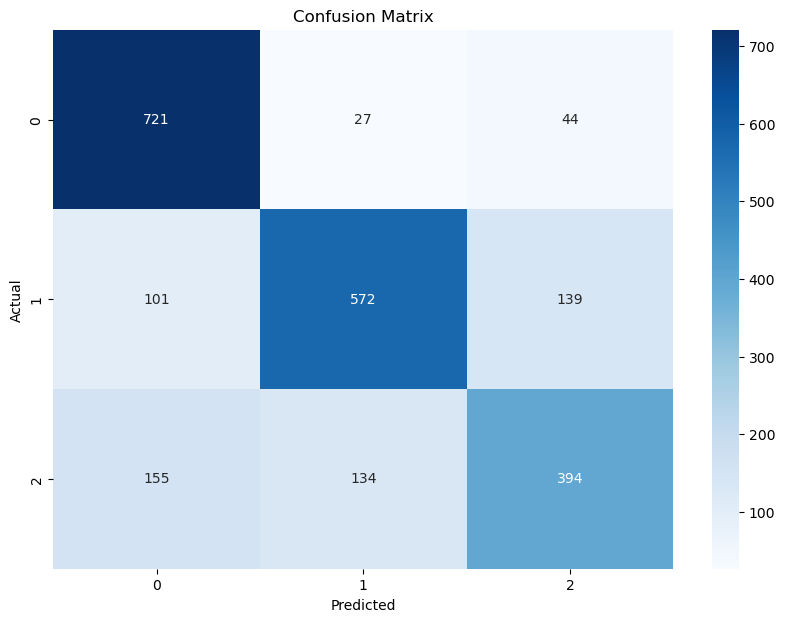

Confusion matrix saved to ./results/confusion_matrix.png


In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score
import os

# Ensure the result directory exists
os.makedirs('./results', exist_ok=True)

# Get predictions
predictions = trainer.predict(test_dataset)
preds = predictions.predictions.argmax(-1)
labels = predictions.label_ids

# Compute F1 score
f1 = f1_score(labels, preds, average='weighted')
print(f"F1 Score on the test set: {f1}")

# Compute confusion matrix
cm = confusion_matrix(labels, preds)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Save the plot
plt.savefig('./results/confusion_matrix.png')
plt.close()

print("Confusion matrix saved to ./results/confusion_matrix.png")
